In [1]:
import re

import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
comments = pd.read_csv('CommentsEpic.csv')

## Data Cleaning and Exploration

#### Bigrams

In [3]:
sample = ['Epic', 'Games', 'Store', 'is', 'an', 'Epic', 'Games', 'store']

In [4]:
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(sample)

# Find bigrams that appear 2+ times
finder.apply_freq_filter(2) 

# Return the 10 n-grams with the highest PMI
print (finder.nbest(bigram_measures.pmi, 10) )

[('Epic', 'Games')]


Let's try it on first 10000 rows of our text

In [5]:
all_text = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [6]:
all_text = nltk.word_tokenize(all_text)

In [7]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('OTHERS', 'CLICKED'), ('Starter', 'Pack'), ('Theft', 'Auto'), ('Rocket', 'League'), ('Grand', 'Theft'), ('Criminal', 'Enterprise'), ('task', 'manager'), ('CLICKED', 'THIS'), ('shopping', 'cart'), ('Watch', 'Dogs')]


#### Wordcloud

In [8]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sample = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [9]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

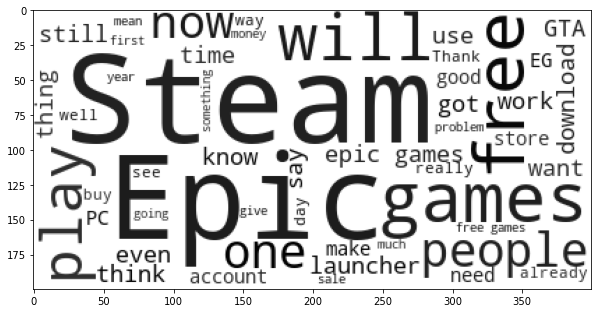

In [10]:
stp = STOPWORDS.copy()
stp.add('game')
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# Generate word cloud
wc.generate(sample)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

In [11]:
# Uncomment to use a subset of the rows.
df = comments #[comments.Key<101]
df.shape

(34367, 4)

Discard of \n, \t, etc. characters that do not help with prediction but might link two words together and make them indistinguishable from one another.

In [12]:
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

Discard any links.

In [13]:
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))

## Sentiment Analysis

- ### __Sentiment Classification using Vader package__

In [14]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

# Initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
sid.polarity_scores('Epic Games Store is better than Steam')

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}

We can add sentiment scores to words manually if we want

In [16]:
new_words = {
    'Steam' : 0,
    'Epic Games' : 0,
}

sid.lexicon.update(new_words)

In [17]:
sid.polarity_scores('Epic Games Store is better than Steam')

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}

In [18]:
df[['vdr neg','vdr neu','vdr pos','vdr compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [19]:
df.head(3)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound
0,My game launcher turned Russian,59.0,2020-05-15 03:24:53,0.0,0.0,1.0,0.0,0.0
1,Every time I refresh my epic game launcher it ...,21.0,2020-05-15 03:44:36,0.0,0.0,1.0,0.0,0.0
2,Premium edition actually,9.0,2020-05-15 03:55:30,0.0,0.0,1.0,0.0,0.0


In [20]:
df.describe()

,Upvote,Key,vdr neg,vdr neu,vdr pos,vdr compound
count,34367.000000,34367.000000,34367.000000,34367.000000,34367.000000,34367.00000
mean,2.657928,335.480286,0.064998,0.792940,0.140665,0.16120
std,6.106541,272.709551,0.118999,0.210775,0.189932,0.44728
min,-47.000000,0.000000,0.000000,0.000000,0.000000,-0.99470
25%,1.000000,111.000000,0.000000,0.697000,0.000000,0.00000
50%,1.000000,261.000000,0.000000,0.829000,0.083000,0.00000
75%,3.000000,526.000000,0.094000,1.000000,0.206000,0.51060
max,212.000000,995.000000,1.000000,1.000000,1.000000,0.99910


- ### Sentiment Classification using Textblob package

In [21]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [22]:
nltk.download('movie_reviews')
tba('My life is a frictionless slide downhill').sentiment

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Sentiment(classification='neg', p_pos=0.374939442175929, p_neg=0.6250605578240714)

In [ ]:
df[['TB Classification','TB pos','TB neg']] = df.Reply.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                        'positive':tba(x).sentiment[1],
                                                                        'negative':tba(x).sentiment[2]}))

In [ ]:
df.head(3)

In [ ]:
df.describe()

In [ ]:
df['TB Classification'].value_counts()

- ### Sentiment Classification using Self-Trained Classifier Module for Kaggle

In [ ]:
import import_ipynb
%run Kaggle_Trained_Classifier.ipynb

In [ ]:
# Transform the 'Reply' so it can be passed to the Self-Trained Classifier
Z = vectorizer.transform(df['Reply'])

In [ ]:
# Predict the Sentiment based on our reply
predicted2 = nb.predict(Z)

In [ ]:
# Look at the size of the prediction result, make sure it is the same as the dataframe's
predicted2.shape

In [ ]:
df.shape

In [ ]:
# Add the Self-Trained Classifier's Classification to the dataframe
df['Classification for Kaggle'] = predicted2

In [ ]:
df.head(3)

In [ ]:
df['Classification for Kaggle'].value_counts()

## Analysis
- ### Positive / Negative Sentiments Ratio

Using the Textblob package, we can see that the Epic Games Store reddit has a mixed sentiment response on posts. 39% bad sentimes and 61% good sentiment.

Using our own trained classification module, there seems to be more Negative sentiments compared to Positive ones. 23% Negative response and 21% Positive sentimes. But if we set aside the Neutral Sentimes, this looks like a very mixed sentiment.

In [ ]:
df['Classification for Kaggle'].value_counts(normalize=True) * 100

In [ ]:
df['TB Classification'].value_counts(normalize=True) * 100

- ### Analysing Compound Sentiment Score Overtime

In [ ]:
# Importing matplotlib and seaborn for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
overTime = df.drop(["Reply","Upvote","Key","vdr neg","vdr neu","vdr pos","TB Classification","TB pos","TB neg","Classification for Kaggle"], axis =1)

In [ ]:
overTime.head(5)

In [ ]:
# Set 'Time' as Index
# This is done to allow grouping by DatetimeIndex
over_time = overTime.set_index(pd.DatetimeIndex(overTime['Time']))

In [ ]:
over_time.head()

In [ ]:
# Group values by Month
g = over_time.groupby(pd.Grouper(freq="M")) 

In [ ]:
# Sum the values of each Month
data_sum = g.sum()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=data_sum.index, y="vdr compound", data=data_sum)
plt.xticks(rotation=15)
plt.title('Total Compound Score Overtime')
plt.show()

In [ ]:
# Find the average values of each month
data_mean = g.mean()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=data_mean.index, y="vdr compound", data=data_mean)
plt.xticks(rotation=15)
plt.title('Average Compound Score Overtime')
plt.show()